# Extracting color palettes from Art Nouveau posters using K-means clustering

![img-1](https://drive.google.com/uc?id=1F6BkDXp5TeLTYbgl3Qqn60QKYbArNNWX)

A poster by the artist Ludwig Hohlwein, accompanied by the color palette information extracted through the processes described in this notebook.
*PIANOS; MUSIKALIEN; THEATER BILLETTS; KONZERT BILLETTS; LAUTERBACH UND KUHN; LEIPZIG by Hohlwein, Ludwig - 1896 - The Albertina Museum Vienna, Austria https://www.europeana.eu/en/item/15508/DG2003_2043. Modified by author.*

## Introduction

---

In this tutorial, we will leverage Europeana APIs to gather data about and analyze various Art Nouveau posters. We will interact with the APIs using [**PyEuropeana**](https://github.com/europeana/rd-europeana-python-api), a Python interface that abstracts away the internal workings of the API and allows for a more seamless integration with the Python ecosystem. We will then analyze the data that we gather using various packages from the Python ecosystem. More specifically, we will be asking the following question:

> ***Can we extract representative color information from Art Nouveau posters?***

### Background information

When it comes to the perfect blend of beauty and function, perhaps no one can quite beat the masterful posters and prints that were produced during the *fin de siècle*: the time period that marks the end of the 19th century and the beginning of the 20th century. This lucrative period, sadly followed by four decades of worldwide war and destruction, gave us remarkable works of art belonging to movements like [**Symbolism**](https://en.wikipedia.org/wiki/Symbolism_(arts)) and [**Art Nouveau**](https://en.wikipedia.org/wiki/Art_Nouveau).

Art Nouveau posters and prints can be identified by many different visual qualities: sleek and organic geometries, symbolism that takes inspiration from nature, and the masterful use of color palettes, both rich and constrained alike. As Art Nouveau is a well-known and well-studied period in art history, it is easy to encounter many scholarly articles that delve into one or more of its visual qualities. However, coming across studies that do the same using computational methods is hard. Finding tutorials that show you how that can be done is even harder. Where might one even find all these posters to begin with?

Europeana offers access to a wide range of digitized representations of cultural heritage objects, aggregated from the archives of the museums found all throughout Europe. The Art Nouveau posters of the 19th/20th century are only a small subset of these cultural heritage objects. These posters can be accessed by using [**Europeana's online search interface**](https://www.europeana.eu/en/search?page=1&qf=TYPE%3A%22IMAGE%22&qf=MIME_TYPE%3Aimage%2Fjpeg&query=Art%20Nouveau&view=grid). The capabilities of the online search interface are limited when compared to the Search API service that Europeana offers. While the former allows you to search Europeana's data in an easily approachable way, the latter allows you to create more complex queries in a programmatic fashion.

### What are the goals of this tutorial?

The goals of this tutorial are twofold:

- To introduce Europeana's Search API using the PyEuropeana package.
- To inspire the reader about the things that can be done by using Europeana's vast Cultural Heritage Object (CHO) data and metadata.



### What do I need to know before following along?

We aimed to make this tutorial very approachable. It does not require a deep knowledge in any of the subjects that it intersects. However, we asume an elementary level of familiarity with the following technologies and concepts:

- Python
- Python packages such as NumPy, Pandas, Pillow and SciKit Learn
- The digital representation of images
- Basic statistics

## Setup

---

### Importing the required packages

Among the packages that we will be using today are [NumPy](https://numpy.org/), [Pandas](https://pandas.pydata.org/), [Pillow (PIL)](https://pillow.readthedocs.io/en/stable/), [Scikit-learn](https://scikit-learn.org/stable/) and [PyEuropeana](https://github.com/europeana/rd-europeana-python-api). We will use NumPy so that we can vectorize certain computations and get a speed boost. Pandas will be used to manipulate the vast amount of data and metadata we get from the Europeana API's. We will use an unsupervised machine learning algorithm from Scikit-learn known as *K-means clustering* to extract color palettes from individual images. PyEuropeana, our Python wrapper around Europeana API's, will be used to fetch data from Europeana.

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import color, util
from sklearn import cluster
import PIL as pil

import pyeuropeana.apis as apis # The Europeana APIs that we will be using today
import pyeuropeana.utils as utils # The utility functions of the pyeuropeana package

### Configuring Matplotlib presets

This section contains the configuration required for the data visualizations that appear in this notebook and can be ignored.

In [ ]:
# Figure
mpl.rcParams["figure.facecolor"] = "1A1C1A"
mpl.rcParams["figure.edgecolor"] = "1A1C1A"

# Axes
mpl.rcParams["axes.facecolor"] = "1A1C1A"
mpl.rcParams["axes.edgecolor"] = "DBDDDB"
mpl.rcParams["axes.labelcolor"] = "DBDDDB"

# Ticks
mpl.rcParams["xtick.color"] = "DBDDDB"
mpl.rcParams["ytick.color"] = "DBDDDB"

# Typography
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.color"] = "DBDDDB"

### Setting the environment variables

What PyEuropeana does under the hood is sending HTTP requests formatted in a certain way to the Europeana API endpoints. Each request has to be signed with an API key to track usage and permissions. Therefore, before starting to use PyEuropeana, we need to get an API key. You can get yours [here](https://pro.europeana.eu/page/get-api).

The functions that we call from PyEuropeana look into your environment variables to find your API key. If you wish to run this notebook locally, you need to provide your own environment key as an environment variable titled `EUROPEANA_API_KEY`. You can do so using the command line or using a config file. Alternatively, in a Notebook environment or in a Python script you can modify the code snippet as outlined below:

```
os.environ['EUROPEANA_API_KEY'] = 'YOUR_API_KEY_HERE' #please insert your api key in between ''
```

## Fetching data

### A brief introduction to Europeana APIs

Europeana offers various API endpoints that allow you to interact with the data that it aggregates in different ways. Detailed information about the APIs that Europeana offers can be found in the [API documentation here](https://pro.europeana.eu/page/apis).

Some of these APIs can be accessed directly via Python using the PyEuropeana package. These APIs are:

- The [**Search API**](https://pro.europeana.eu/page/search): The Search API provides a way to search for metadata records and media on the Europeana repository. Much like on the Europeana website, you can search for keywords aswell as construct complicated queries using a plethora of filters.
- The [**Record API**](https://pro.europeana.eu/page/record): The Record API allows you to get the full metadata that Europeana has about a **Cultural Heritage Object (CHO)**. Metadata is, briefly explained, the data that you have about a piece of data. [**The Europeana Data Model (EDM)**](https://pro.europeana.eu/page/edm-documentation) considers the digitized version of a real, physical cultural artifact (or a digital-born cultural artifact) as a Cultural Heritage Object. The pieces of data that describe a CHO (its title, its provider, its location, its author(s), the link to its digital form) are considered as metadata.
- The [**Entity API**](https://pro.europeana.eu/page/entity): The Entity API allows you to search among the named entities that Europeana maintains and recognizes. These named entities can be many things, but the chief categories are **people**, **topics** and **places**
- The [**IIIF APIs**](https://pro.europeana.eu/page/iiif)

We will be making use of the **Search API** primarily in this tutorial.

### Basic queries with the `apis.search()` function

To make a request to Europeana's Search API using Python, we can use the [`search()` function of the `apis` module](https://rd-europeana-python-api.readthedocs.io/en/stable/apis.html#search). This function requires passing as an argument a search term string to the parameter `query` at minimum. It returns a dictionary which contains metadata about the HTTP request and the actual CHO data.

Let's call the `apis.search()` function with the string "Art Nouveau Poster" passed in as an argument to the parameter `query`.


In [ ]:
response = apis.search(
  query="Art Nouveau Poster"
)

### Working with raw responses

We can inspect the `response` variable to see in-depth what it contains.

In [ ]:
print(type(response)) # apis.search() returns a dictionary
print(response.keys()) # the response has metadata about the HTTP request and the actual data about CHOs
print(response["apikey"]) # the key with which the HTTP request was authenticated
print(response["success"]) # the success status of the HTTP request
print(response["itemsCount"]) # the number of CHO objects fetched by the HTTP request
print(response["totalResults"]) # the number of CHO objects that matched with the provided query

<class 'dict'>
dict_keys(['apikey', 'success', 'requestNumber', 'itemsCount', 'totalResults', 'nextCursor', 'items', 'url', 'params'])
api2demo
True
12
520


The keys of our `response` dictionary are pretty explanatory for the most part. Below are the explanations for some of its keys:

- The `apikey` key holds information about the key with which the HTTP request was authenticated.
- The `success` key holds information about the success status of the HTTP request.
- The `itemsCount` key holds information about the number of CHOs fetched by the HTTP request.
- The `totalResults` key holds information about the number of CHOs that matched with the provided query.
- The `url` key holds information about the formatted HTTP request that was made to the Europeana's Search API endpoint.
- The `params` key records the arguments and parameters that were passed to the `apis.search()` function.

While these keys hold the metadata about the HTTP request that was made, the `items` key holds the actual data that was returned as part of the request. The value of the `items` key is a list of dictionaries. Each dictionary represents the metadata and data about one of the CHOs matched by the query. These dictionaries have many keys whose values can be strings, numeric types, booleans or even other iterables.

In [ ]:
print(type(response["items"])) # response["items"] is a list of dictionaries
print(len(response["items"]) == response["itemsCount"]) # the itemsCount key captures how many dictionaries there are in the items list
print(response["items"][0].keys())
print(len(response["items"][0].keys()))

<class 'list'>
True
dict_keys(['completeness', 'country', 'dataProvider', 'dcCreator', 'dcCreatorLangAware', 'dcTitleLangAware', 'edmConcept', 'edmConceptLabel', 'edmConceptPrefLabelLangAware', 'edmDatasetName', 'edmIsShownAt', 'edmPreview', 'edmTimespanLabel', 'edmTimespanLabelLangAware', 'europeanaCollectionName', 'europeanaCompleteness', 'guid', 'id', 'index', 'language', 'link', 'previewNoDistribute', 'provider', 'rights', 'score', 'timestamp', 'timestamp_created', 'timestamp_created_epoch', 'timestamp_update', 'timestamp_update_epoch', 'title', 'type', 'ugc', 'year'])
34


The metadata that Europeana aggregates about each cultural heritage object is comprehensive and nested in structure. Here, we can see the full metadata for the first CHO retrieved by our query.

In [ ]:
for key, value in response["items"][0].items():
  print(key, value)

completeness 7
country ['Netherlands']
dataProvider ['National Library of the Netherlands - Koninklijke Bibliotheek']
dcCreator ['Elffers,Dick,']
dcCreatorLangAware {'def': ['Elffers,Dick,']}
dcTitleLangAware {'def': ['art nouveau jugenstil nieuwe kunst kunstnijverheid aanwinsten rijksmusem 15 april 16 juli 72 amsterdam']}
edmConcept ['http://data.europeana.eu/concept/base/49', 'http://data.europeana.eu/concept/base/42']
edmConceptLabel [{'def': 'Plakat'}, {'def': 'Lithografie'}, {'def': 'Plakat'}, {'def': 'Litografi'}, {'def': 'Плакат'}, {'def': 'Литография'}, {'def': 'Плакат'}, {'def': 'Літаграфія'}, {'def': 'Juliste'}, {'def': 'Litografia'}, {'def': 'Cartaz'}, {'def': 'Litografia'}, {'def': 'Плакат'}, {'def': 'Литография'}, {'def': 'Afiša'}, {'def': 'Litografija'}, {'def': 'Plakāts'}, {'def': 'Litogrāfija'}, {'def': 'Plakat'}, {'def': 'Litografija'}, {'def': 'Affiche'}, {'def': 'Lithographie'}, {'def': 'Plakát'}, {'def': 'Litográfia'}, {'def': 'Плакат'}, {'def': 'Літографія'}, {'def

### Using utility functions to transform and enrich raw responses

Although you can work with this data in its raw form if you are determined enough, you do not have to. PyEuropeana comes with a set of utility functions that can be leveraged to shape the response data of a Search API call into a friendlier form. The function [**`search2df` of the `utils` module**](https://rd-europeana-python-api.readthedocs.io/en/stable/utils.html#search2df) does exactly this. This utility function can be used to transform the output of the `apis.search()` function into a [**Pandas DataFrame**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), a data structure that is very common in the Python ecosystem.

The function `utils.search2df` has only two parameters: `response` and `full`. The parameter `full` is set to `False` by default, and thus the default behavior of the function is to include only the columns that we believe will be the most relevant for all users.

In [ ]:
response = utils.search2df(
    response,
    full=False
)

print(type(response)) # response is now a dataframe that we can freely manipulate using standard Pandas functions and methods.

<class 'pandas.core.frame.DataFrame'>


Now that `response` is a DataFrame, we can freely manipulate it using standard Pandas functions and methods.

Let's first take a look at what kinds of information the `utils.search2df()` function preserved.

In [ ]:
print(response.shape) # the dataframe consists of 12 rows and 16 columns.
print(response.columns)
print(response.loc[0, :])
print(response.loc[0, "uri"])

(12, 16)
Index(['europeana_id', 'uri', 'type', 'image_url', 'country', 'description',
       'title', 'creator', 'language', 'rights', 'provider', 'dataset_name',
       'concept', 'concept_lang', 'description_lang', 'title_lang'],
      dtype='object')
europeana_id                /92034/GVNRC_RA01_3005100197950620454add1
uri                 http://data.europeana.eu/item/92034/GVNRC_RA01...
type                                                            IMAGE
image_url                                                        None
country                                                   Netherlands
description                                                      None
title               art nouveau jugenstil nieuwe kunst kunstnijver...
creator                                                 Elffers,Dick,
language                                                           nl
rights                     http://rightsstatements.org/vocab/InC/1.0/
provider            National Library of the Ne

The `utils.search2df()` function only reduces the total number of columns/dictionary keys (from 34 to 16) and does not touch the total number of rows, as advertised. Among the important information it preserves are the information about the CHO's internal Europeana ID, its URI, its type and its image URL.

The image URL is especially important for our use case, because we will shortly be using those URLs to get the actual images loaded into our Python environment. Before that, let's tidy up our DataFrame a little bit. We will preserve information about id, type, image URL, title and creator. We will also drop any rows that do not have data in the `image_url` column along with the rows that have duplicate titles.

In [ ]:
response = (
    response
    .loc[:, ["europeana_id", "image_url", "type", "title", "creator"]]
    .dropna(axis=0)
    .drop_duplicates(subset="title")
    .reset_index(drop=True)
)

In [ ]:
response

,europeana_id,image_url,type,title,creator
0,/9200495/yoolib_inha_3664,http://tools.yoolib.net/i/s4/inha/files/3001-4...,IMAGE,[Salon des Cent. Janvier 1898],"Causé, Emil (1867-19??)"
1,/92002/BibliographicResource_1000093325536_source,http://www.theeuropeanlibrary.org/images/treas...,IMAGE,Baltic artists' painting exhibition,"Borchert, Bernhard"
2,/92002/BibliographicResource_1000093325505_source,http://www.theeuropeanlibrary.org/images/treas...,IMAGE,The Olympic Games,"Hjortzberg, Olle"
3,/92002/BibliographicResource_1000093325434_source,http://www.theeuropeanlibrary.org/images/treas...,IMAGE,Latvijas precu izstade,"Steinbergs, Oskars"
4,/2064108/Museu_ProvidedCHO_Kunstbibliothek__St...,http://www.smb-digital.de/eMuseumPlus?service=...,IMAGE,L'Art Nouveau. Exposition permamente,"Félix Vallotton (28.12.1865 - 29.12.1925, Entw..."


Now that we have a tidier and more concise DataFrame, we can start enriching it by loading the actual image data. Recall that the column `image_url` contained URLs through which we can fetch individual images. We can test whether this statement holds by taking one URL and using any browser we want to access it. You can copy the output of the cell below to do exactly that.



In [ ]:
print(response.loc[4, "image_url"])

http://www.smb-digital.de/eMuseumPlus?service=ImageAsset&module=collection&objectId=1829993&resolution=superImageResolution#4301743


In principle, any Python code that makes a HTTP GET request to these URLs and then processes the response can be used to get the image data loaded into our Python environment. PyEuropeana has a utility function that does exactly that. The function `utils.url2img()` uses the [**urllib**](https://docs.python.org/3/library/urllib.html) module of the standard library and Pillow (PIL) to do exactly that.

The [`utils.url2img`](https://rd-europeana-python-api.readthedocs.io/en/stable/utils.html#url2img) function accepts an URL as an argument and returns a [`PIL.image`](https://pillow.readthedocs.io/en/stable/reference/Image.html) object.

In [ ]:
test_image = utils.url2img(response.loc[4, "image_url"])
print(type(test_image))

<class 'PIL.Image.Image'>


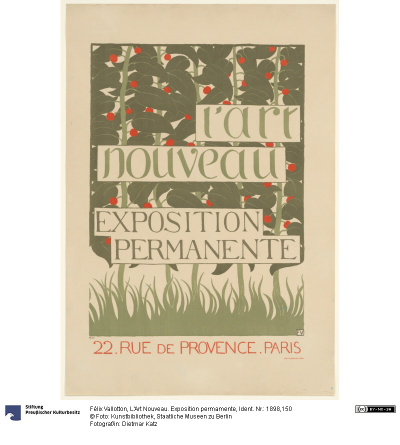

In [ ]:
test_image.reduce(2) # Display the image, scaled by 0.50

We now know how to query Europeana to get data and metadata about the CHOs that we want. We've also seen how we can manipulate and enrich the raw response that we get from the API call using utility functions.

Despite all this, our initial query can still use some work. The response that we got from the API call included some redundant data and we had to "clean" up a little by dropping the CHOs that did not have an image data. Perhaps we can avoid having to do so and get more relevant data if we modify our initial query.


### Advanced queries with the `apis.search() function`

The only argument that we passed into the `apis.search()` function was the string `"Art Nouveau Poster"` for the  `query=...` parameter. If you took a look at the [API docs for the `apis.search()` function](https://rd-europeana-python-api.readthedocs.io/en/stable/apis.html#search), you probably noticed that the function has many other parameters besides `query`. These parameters allow you to send to the API a carefully crafted query. Through them, you get more relevant data that requires less processing on your end. When you utilize these parameters you can match or even exceed the full expressiveness of the online search interface.

[The Search API documentation located in Europeana API docs](https://pro.europeana.eu/page/search) contains more information about what the many possible parameters are. When combined with the Python API docs we've just linked above, you have all the documentation you need to craft a precise query.

Let's now try to refine our initial query by utilizing more of the parameters that we have in our disposal. We will try to fetch the graphic works (posters, prints, advertisements) of prominent Art Nouveau artists from Continental Europe. The list of artists whose works we will try to search for were taken from [this Wikipedia page](https://en.wikipedia.org/wiki/Art_Nouveau_posters_and_graphic_arts).



In [ ]:
response = apis.search(
  query="""
  who:(
  "Henri de Toulouse-Lautrec" OR "Jules Chéret" OR "Eugène Samuel Grasset" OR "Mucha" OR "Steinlen" OR "Berthon" OR "Livemont" OR "Meunier"
  OR "Sattler" OR "Eckmann" OR "Witzel" OR "Klimt" OR "Roller" OR "Kurzweil" OR "Andri" OR "Moser" OR "Zeymer" OR "Hohlwein"
  )
  """,
  qf='what:(Poster OR Print OR Engraving OR Illustration OR Lithograph)',
  reusability="open AND permission",
  media=True,
  landingpage=True,
  profile="rich",
  sort="europeana_id",
  rows=750
)


The query above contains parameters that are well-explained in the API docs (such as `rows` and `media`) aswell as some confusing ones.) Let's try to clarify it a little:

- The multi-line string that we passed into the `query` parameter is formatted as specified by the [Search API syntax document here](https://pro.europeana.eu/page/search#syntax). We are using an OR statement to specificy that we want to match multiple keywords.

- The `who:(...)` prefix of the query string is an aggregated search field. Europeana Search API has [a whole list of search fields](https://pro.europeana.eu/page/search#search-fields) that you can pass in either into the `query` parameter or the `qf` parameter. The aggregated search field `who` here allows us to search for CHO data based on their authors.

- The `query` parameter receives a long Python string that is basically the name of the artists we want to search for. Pay attention to how we can search for full names (Henri de Toulouse-Lautrec) aswell as for surnames only (Klimt). A string like this can be easily generated programmatically.

- We are using the `qf` parameter to refine our inital search. `what:(...)` is another aggregate search field that allows you to search CHO data based on topic. The topics that we specified here were taken [from this page about topics recognized by Europeana](https://www.europeana.eu/en/collections/topics).

As with the previous query, the response of this API call is a nested dictionary that can be transformed into a DataFrame and enriched using our utility methods. The code snippet below is an aggregation of all the same steps we've used for our previous query. As an extra we are using `Series.apply()` from Pandas to cast our `utils.url2img()` function to each row. We are also checking for duplicates based on titles and dropping duplicate items along with rows that we could not manage to get data for.

In [ ]:
# transform the response dictionary to a dataframe
response = utils.search2df(response, full=False)

# format and tidy up the dataframe
response = (
    response
    .loc[:, ["europeana_id", "image_url", "title", "creator"]]
    .dropna(axis=0)
    .drop_duplicates(subset=["title", "europeana_id"])
    .reset_index(drop=True)
)

# enrich the dataframe w/ image data
response["image"] = response["image_url"].apply(utils.url2img)

# tidy up the dataframe again: drop the `image_url` column and image request failures
response = (
    response
    .loc[:, ["image", "europeana_id", "title", "creator"]]
    .dropna(axis=0)
    .reset_index(drop=True)
)

Let's take a look at the DataFrame that we've created to try and understand our small dataset better. We can start by looking at the general shape of the DataFrame and at the data types of its columns.

In [ ]:
print(response.shape) # we have around 240 rows and 4 columns
print(response.info()) # all columns have non-numeric data, no rows with duplicate values

(242, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         242 non-null    object
 1   europeana_id  242 non-null    object
 2   title         242 non-null    object
 3   creator       242 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB
None


Since we based our search off of a list of artists, it might be a good idea to also look at how many graphic works we have per artist.

In [ ]:
response["creator"].value_counts()

#Ludwig_Hohlwein_Künstler_in                      38
#Koloman_Moser_Künstler_in                        24
#Jules_Chéret_Künstler_in                         22
#Alfred_Roller_Künstler_in                        18
#Théophile_Alexandre_Steinlen_Künstler_in         16
Steinlen, Théophile-Alexandre                     15
#Henri_de_Toulouse-Lautrec_Künstler_in            14
#Alfons_Maria_Mucha_Künstler_in                   13
#Josef_Rudolf_Witzel_Künstler_in                   7
#Eugène_Samuel_Grasset_Künstler_in                 7
#Georges_Meunier_Künstler_in                       7
#Privat_Livemont_Künstler_in                       6
Lithographische Anstalt Albert Berger              6
#Henri_Meunier_Künstler_in                         5
Mucha, Alphonse                                    4
#Gustav_Klimt_Künstler_in                          4
#Josef_Sattler_Künstler_in                         3
Mucha, Alfons                                      3
Meunier, Henri Georges                        

It looks like we managed to get a good number of individual images for most of the artists that we wanted to investigate. There are some duplicate names in the list that can be worked with to further clean the dataset, but we will not be doing that.

Lastly, let's look at some of the images that we've loaded into our Python environment. How about these posters drawn by [Henri Meunier?](https://en.wikipedia.org/wiki/Henri_Meunier)

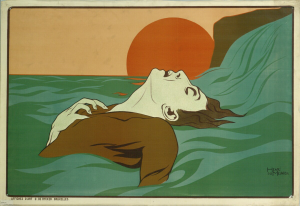

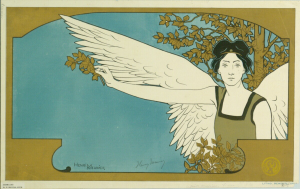

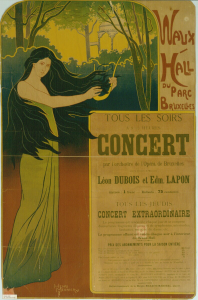

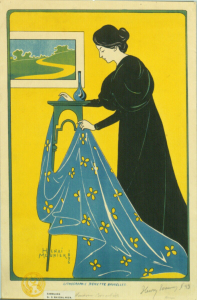

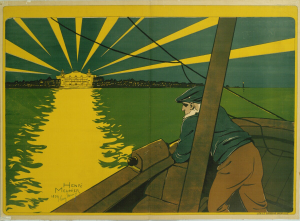

In [ ]:
subset = response.loc[response["creator"] == "#Henri_Meunier_Künstler_in", "image"]
for img in subset:
  display(img.reduce(4)) # scaled by 0.25

Everything looks in order! Now that we have a dataset of Art Nouveau posters and prints we can work with, we can get on to analyzing them.


## Extracting representative color information

Let's briefly remember our initial question:

> ***Can we extract representative color information from Art Nouveau posters?***

Before going on and writing the Python code that accomplishes this in one way, it may serve us well to really understand what we mean by this.

### What's in a poster?

For humans, **a poster is a specific kind of image that has both an aesthethic and a semantic purpose.** For a digital computer **an image is nothing more than a long series of ones and zeros.** These ones and zeros, when read in a specific order and interpreted in a particular way, contain the information that is needed to recreate the image on a screen.

Our computer screens are (generally) made up very small clusters of three lamps that emit red, green and blue light. The logical representation of each of these clusters of lamps is called a [***pixel***](https://en.wikipedia.org/wiki/Pixel). A *pixel* is the basic logical unit in computer graphics. The series of ones and zeroes can be mapped to pixels and made to manifest on our screens. This means that **every digital image can be represented as a collection of pixels.** For those that want a more structured explanation:

- An image is a set of n pixels.
- Each pixel exists as a point in a 3D [color space](https://en.wikipedia.org/wiki/Color_space).
- This color space is generally the [RGB color space](https://en.wikipedia.org/wiki/RGB_color_spaces).

![img-2](https://drive.google.com/uc?id=1RJqxFaTX5whZXc5WSZ3zk6ZeJyLC-8SM)

The RGB color cube.*By SharkD - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=9803320*

- The smallest value that each digit can take in that ordered triple is 0, and the largest value is 255. For each color channel, 0 means **no color of that channel** and 255 means **full intensity.**

All this can be summarized in the following fashion. If we care only about the color, a poster that looks like the image below for us...






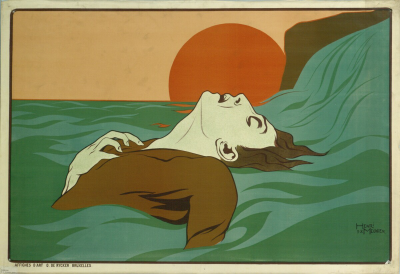

In [ ]:
display(subset.iloc[0].reduce(3))

...looks more or less like this for a computer:


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


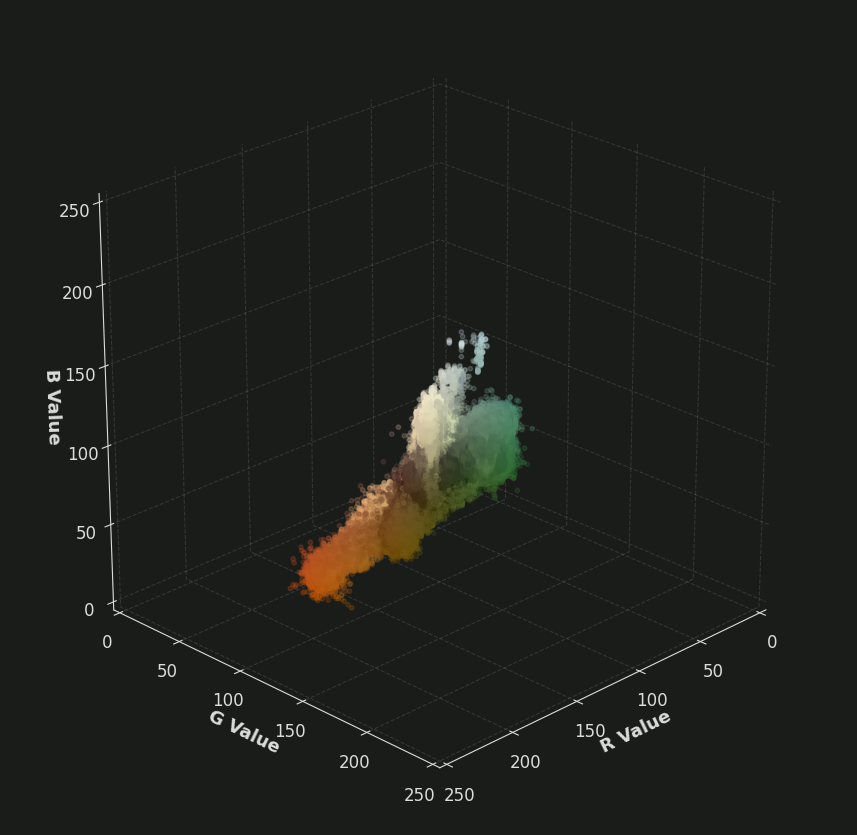

In [ ]:
# --- data prep ---
# get one of the images from subset as sample_poster
sample_poster = subset.iloc[0]

# convert to a df for more convenient plotting
sample_poster_rawdata = np.array(sample_poster, dtype="uint8").reshape(-1, 3)
sample_poster_df = pd.DataFrame(sample_poster_rawdata, columns = ["red_val", "green_val", "blue_val"])

# add hexcode format for colors
def rgb_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

sample_poster_df['hex'] = sample_poster_df.apply(lambda r: rgb_to_hex(*r), axis=1)

# --- viz setup ---
#create figure
fig = plt.figure(figsize = (10.80, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1, projection="3d")

# configure params
# axis labels
ax.set_xlabel("R Value",
              fontsize=13,
              fontweight="bold")

ax.set_ylabel("G Value",
              fontsize=13,
              fontweight="bold")

ax.set_zlabel("B Value",
              fontsize=13,
              fontweight="bold")


# grid, spines and axes
# set ax x, y, z lims
ax.set_xlim(0, 250)
ax.set_ylim(0, 250)
ax.set_zlim(0, 250)
#Make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
ax.yaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
ax.zaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
# make the grid lines hatched
ax.xaxis._axinfo["grid"]['linestyle'] =  "--"
ax.yaxis._axinfo["grid"]['linestyle'] =  "--"
ax.zaxis._axinfo["grid"]['linestyle'] =  "--"

# 3D view
ax.view_init(elev=25., azim=45.)

# --- plotting ---
scatter1 = ax.scatter(xs=sample_poster_df.loc[:, "red_val"].astype(int),
                      ys=sample_poster_df.loc[:, "green_val"].astype(int),
                      zs=sample_poster_df.loc[:, "blue_val"].astype(int),
                      s=10,
                      marker="o",
                      facecolors=sample_poster_df["hex"],
                      alpha=0.25)

fig.show()


The 3D scatterplot above plots 985,200 individual points representing all the pixels of our example poster in a 3D space. Seeing the image in this form helps us to finally rephrase our problem. Our question can now be transformed into the following:

>***Can we extract representative color information from separate collections of points in 3D space?***

The question is beginning to look a lot like something that a computer can solve programmatically. Let's keep attacking the question further.

### How to pick representative colors?

When faced with a visual scene, we humans can very easily point at the colors that we deem to be dominant. For example, in the poster above one might point at the dirty orange of the setting sun or the faded green of the waves as being the "representative" colors. We seem to possess the ability to extract from an image *K* colors we deem to be "representative." by using our own eyes. In fact, we have name for these most "representative" or "important" colors. We call those the ***color palette*** of an image.

How might we instruct a computer to do the same? If we take a peek at the 3D scatterplot again, we can see that the individual points are mostly aggregated or *clustered* around certain regions of the 3D RGB space. This is the key insight behind solving our problem programmatically. If we can somehow determine these clusters and their centers, we can take the cluster centers and construct a representative color palette.

Phrased this way, our question becomes the following:

>***Can we extract the individual cluster centers from separate collections of points in 3D space?***



### Picking the appropriate algorithm

Luckily for us, we are not about to reinvent the wheel. [There is a whole field of inquiry within Computer Science that deals with problems related to clustering](https://en.wikipedia.org/wiki/Cluster_analysis). In fact, the task of **trying to find the *k* colors that best represent an image has also been studied.** We have a scholarly interest in the issue, but this problem (actually called [*Color Quantization*](https://en.wikipedia.org/wiki/Color_quantization)) has been studied under the umbrella of digital image processing in order to come up with a way to reduce the storage space of an image without altering its appearance in a major way.

One way of reducing thousands of colors to only a select most representative few is using an algorithm known as [***k-means clustering***](https://en.wikipedia.org/wiki/K-means_clustering). You can find many explanations of this algorithm online ([here's one](https://www.youtube.com/watch?v=4b5d3muPQmA)). It is highly suggested that you take a look at the link to see the explanation of a *naive* version of the K-means algorithm without any optimizations.  We will be using [an optimized version as found in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). As explained in the documentation, this version of K-means uses an initialization method known as [***K-means++***](https://en.wikipedia.org/wiki/K-means%2B%2B) to pick better initials instead of random initials. It also uses an algorithm known as [***Elkan's k-means***](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) to speed up the cluster finding process.

### Running K-means on a sample poster

Let's now see the K-means algorithm in action by running it on the Henri Meunier poster we've dissected above. We will set *K* to be six and hopefully produce a color palette consisting of six sufficiently representative colors. Six is just an arbitrary integer: you can set *K* to be anything you want, but be mindful of very small values like one or very large values like twenty or thirty. The former number will mostly likely result in a not-so-representative palette, and the latter numbers will most likely have the algorithm pick up many colors that are variations on the actual palette.

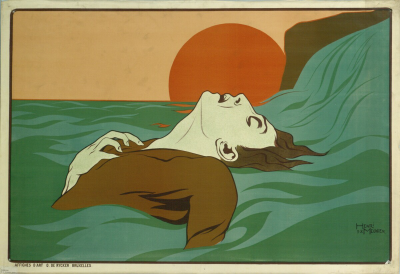

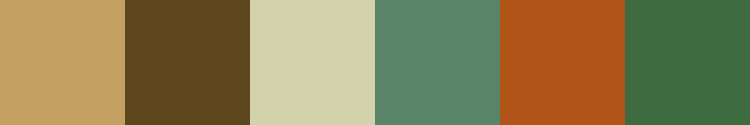

In [ ]:
# run k-means clustering on sample_poster_rawdata
kmeans = cluster.KMeans(n_clusters=6)
kmeans = kmeans.fit(sample_poster_rawdata)

# save centroids and labels of each pixel
centroids = kmeans.cluster_centers_

# create a palette from centroids
palette = [
  pil.Image.new("RGB", (125, 125), tuple(col)) for col in centroids.astype(int)
]
palette = np.hstack([np.asarray(swatch) for swatch in palette])
palette = pil.Image.fromarray(palette)

# print the  image and the palette
display(sample_poster.reduce(3)) # shrinked for ease of viewing
palette

Taking a look at the palette, we can say that the K-means clustering algorithm did a pretty good job in coming up with the color palette of the image! All of the colors that we would have picked by hand are also picked by the K-means algorithm. All in all, this seems to be a success.

To understand what the algorithm has done, let's plot all the pixels in the 3D space again. But this time, let's also plot the cluster centers to see if they really fit.

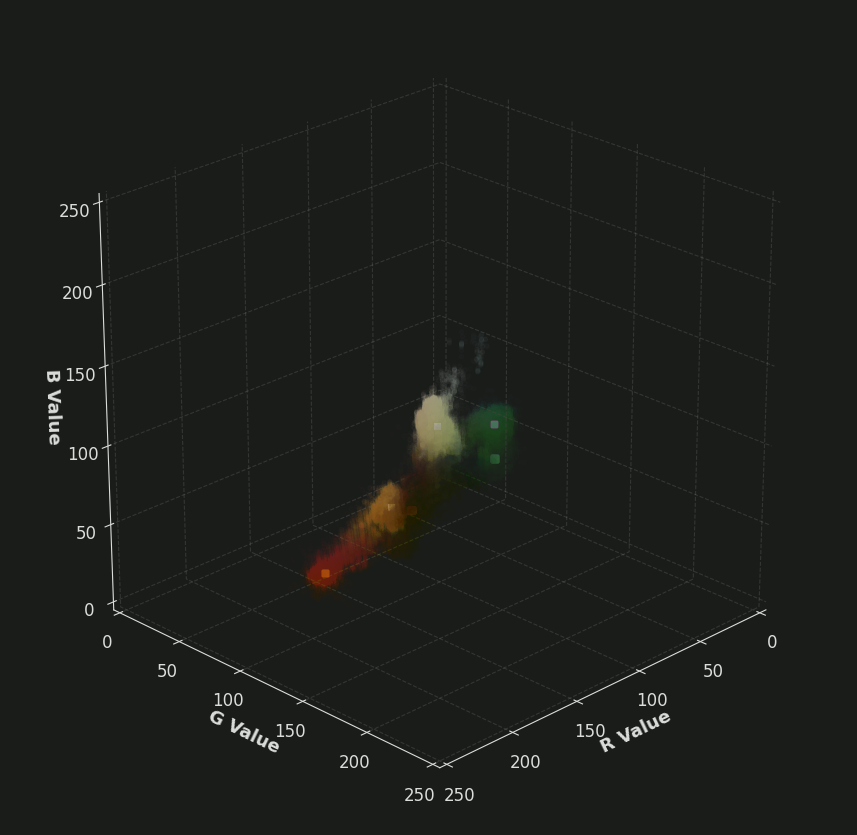

In [ ]:
# create a df for centroids
centroids_df = pd.DataFrame(centroids.astype(int), columns = ["red_val", "green_val", "blue_val"])
centroids_df["hex"] = "white"

# --- viz setup ---
#create figure
fig = plt.figure(figsize = (10.80, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1, projection="3d")

# configure params
# axis labels
ax.set_xlabel("R Value",
              fontsize=13,
              fontweight="bold")

ax.set_ylabel("G Value",
              fontsize=13,
              fontweight="bold")

ax.set_zlabel("B Value",
              fontsize=13,
              fontweight="bold")


# grid, spines and axes
# set ax x, y, z lims
ax.set_xlim(0, 250)
ax.set_ylim(0, 250)
ax.set_zlim(0, 250)
#Make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
ax.yaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
ax.zaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
# make the grid lines hatched
ax.xaxis._axinfo["grid"]['linestyle'] =  "--"
ax.yaxis._axinfo["grid"]['linestyle'] =  "--"
ax.zaxis._axinfo["grid"]['linestyle'] =  "--"

# 3D view
ax.view_init(elev=25., azim=45.)

# --- plotting ---
# plot normal points
ax.scatter(xs=sample_poster_df.loc[:, "red_val"].astype(int),
           ys=sample_poster_df.loc[:, "green_val"].astype(int),
           zs=sample_poster_df.loc[:, "blue_val"].astype(int),
           s=10,
           marker="o",
           facecolors=sample_poster_df["hex"],
           alpha=0.01)

# plot centroids
ax.scatter(xs=centroids_df.loc[:, "red_val"].astype(int),
           ys=centroids_df.loc[:, "green_val"].astype(int),
           zs=centroids_df.loc[:, "blue_val"].astype(int),
           s=20,
           marker="s",
           facecolors=centroids_df["hex"],
           linewidths=1,
           edgecolor="white",
           alpha=1)

fig.show()

In the 3D scatterplot above all of the points have been faded until they are nearly invisible so that we can see the cluster centers better. This was necessary because what we had was a dense point cloud with 985,200 individual points. The white squares roughly mark the location of the cluster centers. One can say that the algorithm managed to place the cluster centers near the vicinity where a human agent would have done if it was given the task.

### Improving K-means performance by changing the color space

There's one more tweak that we have to add to our workflow before we go off into extracting the color palette information for the whole dataset. That tweak has to do with changing the color space in which the clustering happens from the RGB color space to the [**CIELAB color space**](https://en.wikipedia.org/wiki/CIELAB_color_space). Doing this can improve the quality or the "fidelity" of the palettes that we are extracting. By quality here, we mean having a color palette that is closer to what we'd construct by hand. Explaining the reason behind this improvement is beyond the scope of this tutorial. However, good leads can be found in the Wikipedia pages of the concept [***perceptual uniformity***](https://en.wikipedia.org/wiki/Color_difference#Tolerance).

Let's now convert the sample poster to the CIELAB color space, run the algorithm and then look at the results. Here's the code from converting the image from RGB to CIELAB:

In [ ]:
# --- convert images to LAB colorspace ---
sample_poster_rawdata = color.rgb2lab(sample_poster_rawdata) # use scimage transform function

And finally, let's run the k-means clustering again (this time in CIE LAB space) to see the result.

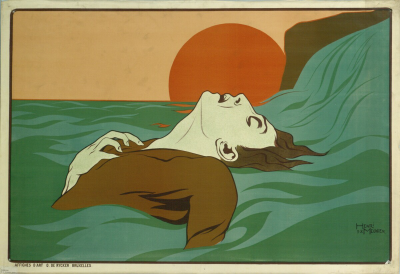

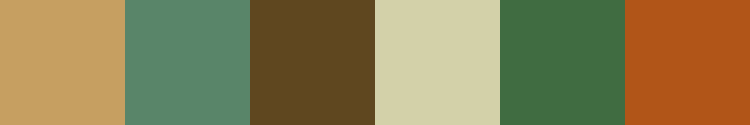

In [ ]:
# run k-means clustering on sample_poster_rawdata
kmeans = cluster.KMeans(n_clusters=6)
kmeans = kmeans.fit(sample_poster_rawdata)
# save cluster centroids as palette
palette = kmeans.cluster_centers_
# reconvert to RGB for display
palette = color.lab2rgb(palette)
palette = util.img_as_ubyte(palette) # needed for pil compability
# create a displayable image from numpy arrays
palette = [
  pil.Image.new("RGB", (125, 125), tuple(col)) for col in palette
]
palette = np.hstack([np.asarray(swatch) for swatch in palette])
palette = pil.Image.fromarray(palette)
# print the  image and the palette
display(sample_poster.reduce(3)) # shrinked for ease of viewing
palette

For this example here the difference in result seems to be minimal, if there is any to begin with. The brightness of the colors in the palette seem to be more in tune with the actual poster. 

Even though we did not achieve a substantial improvement, the theory is on our side and we can be sure that this will give better results over a larger dataset. Now, lets tidy up all the code we've written so far and apply it to the whole dataset.

### Extracting the color palette information for the whole dataset

The code snippets below tidies up all the code we've written up to this point and applies it to the whole dataset. In summary, what we are doing is equivalent to creating two new columns in the `results` dataframe. One column will hold a list of six hexadecimal numbers in string format, each representing a color. The other column will hold the Pillow images of the said palettes so that they can be displayed in a notebook environment.

We first create a new column called `TEMP_image_rawdata`. This holds the raw pixel and color data from each of the images that we hold. The colors are specified in the CIELAB color space.

In [ ]:
response["TEMP_image_rawdata"] = (
    response["image"]
    .apply(lambda x: np.asarray(x, dtype="uint8").reshape(-1, 3)) # turn image into a numpy array
    .apply(lambda x: color.rgb2lab(x)) # transform rgb array into a cielab array
)

We then create another column called `palette_rawdata` to hold the cluster centers that we get after running k-means clustering on each element of the `TEMP_image_rawdata` column. A word of warning for those who want to run this notebook locally: mixing big images, K-means clustering and dataframes is not the most computationally efficient way of batch computing the color palette information of over a hundred images. Computing all the color palettes with orthodox K-means takes a long time. The below code snippet uses [**Mini Batch K-Means**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) instead of orthodox K-means. This is a K-means algorithm that runs exponentially faster than orthodox K-means at a small cost of accuracy. Even then the whole process takes around five minutes to complete, so be vary.

In [ ]:
# initialize a mini batch k-means object with 6 clusters
kmeans_instance = cluster.MiniBatchKMeans(
  n_clusters=6,
  init="k-means++",
  batch_size=1024
)

# run k-means on TEMP_image_rawdata
# kmeans_instance.fix(x) actually returns a whole object that contains the
# clustering info for all points. We only get the cluster centers by
# accessing the .cluster_centers_ property of the returned object.
response["palette_rawdata"] = (
    response["TEMP_image_rawdata"]
    .apply(lambda x: kmeans_instance.fit(x).cluster_centers_)
)

Since the raw color data of each individual color as recorded in `TEMP_image_rawdata` is in the CIELAB color space, so are the six cluster centers that we get as the result of K-means clustering. To make that information more accessible, let's transform them back to the RGB space. From there, we can do two things to make our results interpretable: 

- Create Pillow images so that we can display the color palettes in console.
- Rewrite the RGB palettes as hexcode.

The code snippet below does exactly that:

In [ ]:
# transform color representations from CIE LAB to RGB
response["palette_rawdata"] = (
  response["palette_rawdata"]
  .apply(lambda x: color.lab2rgb(x)) # transform the color representations into rgb space
  .apply(lambda x: util.img_as_ubyte(x)) # transform color representations from floats to 8-bit unsigned integers
)

In [ ]:
# create a Pillow image for each palette
response["palette_image"] = (
  response["palette_rawdata"]
  .apply(lambda x: [pil.Image.new("RGB", (125, 125), tuple(col)) for col in x])
  .apply(lambda x: np.hstack([np.asarray(swatch) for swatch in x]))
  .apply(lambda x: pil.Image.fromarray(x))
)

# rewrite the RGB palettes as hexcode
response["palette_rawdata"] = (
    response["palette_rawdata"]
    .apply(lambda x: [rgb_to_hex(*list(swatch)) for swatch in x])
)

Let's tidy up the `response` DataFrame a little bit and then finally look at the results.

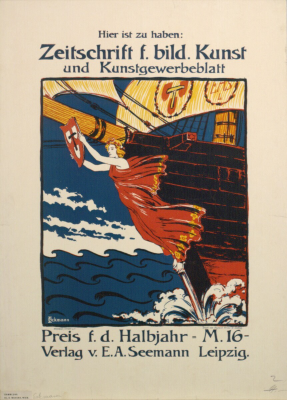

['#eadbc1', '#322c2b', '#a54629', '#2a455b', '#deac4f', '#cdc3ab']


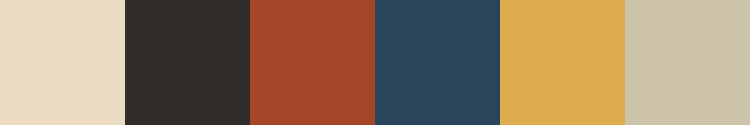

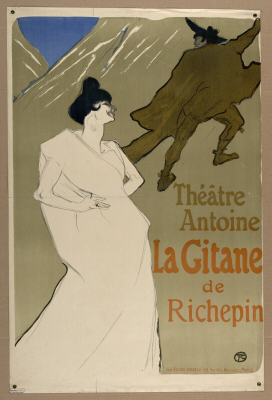

['#5e481d', '#a49471', '#d6c7ac', '#897b58', '#485d87', '#1d1b16']


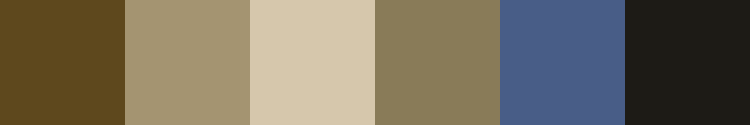

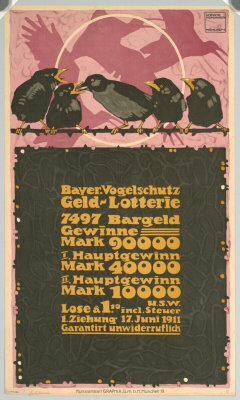

['#6b5835', '#dda396', '#d39e44', '#454434', '#b4686a', '#e2d1b8']


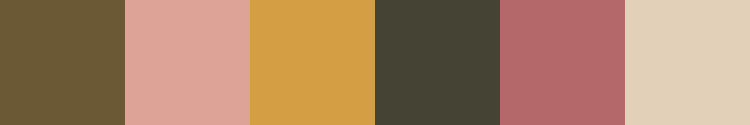

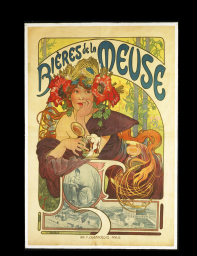

['#505e54', '#dec06e', '#020201', '#854d31', '#ece1b8', '#988556']


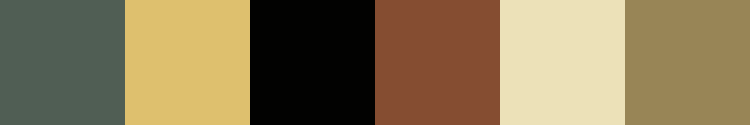

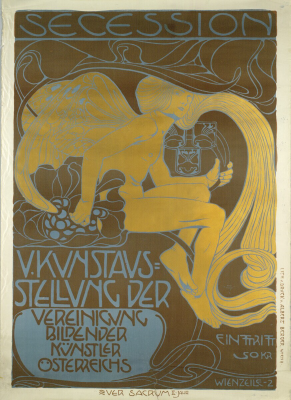

['#656252', '#ba9942', '#dfdabf', '#624f2e', '#728283', '#9d8e61']


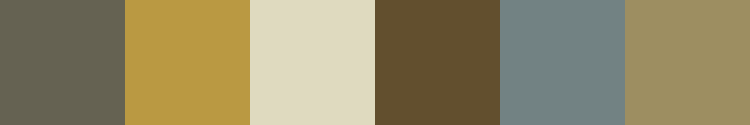

In [ ]:
from random import randint

response = (
  response.loc[:, ["europeana_id", "title", "creator", "image", "palette_image", "palette_rawdata"]]
)

# select 5 images at random, show images and palettes
for i in range(0, 5):
  idx = randint(0, len(response))
  display(response.loc[idx, "image"].reduce(3))
  print(response.loc[idx, "palette_rawdata"])
  display(response.loc[idx, "palette_image"])

## Conclusion

With this, we finally answered the question that we had set out the answer. Through the use of PyEuropeana and several packages in the Python ecosystem, we were able to create a dataset of Art Nouveau posters and extract representative color information (color palettes) for each of them.

As we've previously mentioned, the concept of extracting the color palette of an image has a practical usecase in computer science. These palettes can then be used (along with a series of methods known as [***dithering***](https://en.wikipedia.org/wiki/Dither)) to create visually similar versions of the original images that take up less space in computer memory. The color palette information that we extracted can also be used for other purposes such as:

- Multimedia search: if you know what colors dominate an image, you can search images by color.
- Artistic reuse: perhaps these color palettes can be used to create new images (by hand or algorithmically) that share the same color palette.
- Scholarly study: the color palette information can be used to further classify and segment the posters. Alternatively, they can also be studied on their own.
